# Imports, api, datasets and functions to use Naswot metric

In [ ]:
!pip install nats_bench
!wget "https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar"
!tar -xf "NATS-tss-v1_0-3ffb9-simple.tar"

!pip install xautodl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-27 13:47:15--  https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar [following]
--2022-06-27 13:47:15--  https://www.dropbox.com/sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c65f0a3ac1d32886c900ff0a1.dl.dropboxusercontent.com/cd/0/inline/BoCzN1GuzRoXSiStcXBAiohrOPAY4_i5LEIw6eiahDdy13tuC6tjI5guYlekq1Iz5KrfZCwXBTy09Sg6rEkkVWbEc8SMhrIX3Iv1gtwAMecuRzYnKwoVScPPeKFE6pc

In [ ]:
!wget 'https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1' -O ImageNet16.tar.gz
!tar -xf "ImageNet16.tar.gz"

--2022-06-27 13:47:46--  https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/o2fg17ipz57nru1 [following]
--2022-06-27 13:47:46--  https://www.dropbox.com/s/dl/o2fg17ipz57nru1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd96d94aacfc61016db4cb39929.dl-eu.dropboxusercontent.com/cd/0/get/BoAQ5yAKLtRRwxyTKVuvrzMVPsrgFdxcH6lYhnw0IU0RwPDcmWGKxXz2ueadGHupM9HtvOkh5D-SILn5bp8JfY1ymRqCOmiFWaBL7WZ-p01sOfZQa1KWYzF2W54DAY-CIpwQHeyQt1bnTieamCcJ00AxYQSSUJxTWy_OrAJBv2ghlavWB_UkDjY_rM8hlnvDdsk/file?dl=1# [following]
--2022-06-27 13:47:47--  https://ucd96d94aacfc61016db4cb39929.dl-eu.dropboxusercontent.com/cd/0/get/BoAQ5yAKLtRRwxyTKVuvrzMVPsrgFdxcH6lYhnw0IU0RwPDcmWGKxXz2ueadGHupM9HtvOkh5D-SI

In [ ]:
!git clone https://github.com/gsuriano/Project8_Group5.git

!mv Project8_Group5/* /content/

Cloning into 'Project8_Group5'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from xautodl.datasets.DownsampledImageNet import ImageNet16
from torchvision import transforms
import numpy as np
import torch
import operator
from numba import cuda
from nats_bench import create
from xautodl.models import get_cell_based_tiny_net
import random
import pandas as pd
import os
from scipy import stats
import time
import operator
import math
import seaborn as sns
import matplotlib.pyplot as plt
from models import *
from pruners import *
from pruners import predictive
from pruners.predictive import find_measures
from copy import deepcopy
import math

In [ ]:
# Create the API instance for the size search space in NATS
api = create("/content/NATS-tss-v1_0-3ffb9-simple/", 'tss', fast_mode=True, verbose=False)

#tranforms to tensor the input data, no data augmentation needed
transform = transforms.Compose([
    transforms.ToTensor()
])

#funtion to retrieve the train loader
def get_data(dataset, batch_size, pin_memory=True):
  transform = transforms.Compose([
    transforms.ToTensor() ])
  if dataset == 'cifar10':
    train_data = dset.CIFAR10 ("/content/Cifar10", train=True ,transform = transform, download=True)

  elif dataset == 'cifar100':
    train_data = dset.CIFAR100("/content/Cifar100", train=True ,transform = transform, download=True)
    
  elif dataset == 'ImageNet16-120':
    train_data = ImageNet16("/content/ImageNet16", True, transform = transform)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory)
  
  return train_loader


In [ ]:
def getnumclass(dataset):
  return 10 if dataset == 'cifar10' else 100 if dataset == 'cifar100' else 120 

#log of kernel function
def logdet(K):
    s, ld = np.linalg.slogdet(K)
    return ld

#weight initialization function
def init(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)

# function to compute Hamming Distance, using cuda jit library
# A is the binary codification of the current Relu output
# C is the hamming distance (result of this function) 
@cuda.jit
def constructK(A,C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += operator.xor(bool(A[i, k]),bool(A[j, k]))
        C[i, j] = tmp

In [ ]:
# hook registered on forward in each Relu instance of the network
# here we binarize the output of Relu, setup the parameters to parallelize with cuda.jit
# construct the kernel matrix
def counting_forward_hook(module, inp, out):
  if isinstance(inp, tuple):
    inp = inp[0]
  inp = inp.view(inp.size(0), -1)
  inp = (inp > 0).float()

  inp = cuda.to_device(inp)
  temp = cuda.device_array((inp.shape[0], inp.shape[0]))

  threadsperblock = (8,8)
  blockspergrid = (16,16)

# Start the kernel 
  constructK[blockspergrid, threadsperblock](inp, temp)

# Copy the result back to the host
  global Ktemp, device
  temp = torch.tensor(temp.copy_to_host()).to(device)
  temp = inp.shape[1]-temp
  Ktemp = Ktemp + temp


#Generate child functions
Mutation, majority vote, inversion and crossover

In [ ]:
# function to check if there is a skip connection in the network 
def control(arch):

  skip = [ node[0] == 'skip_connect' for node in arch]
  
  if sum(skip) == 0:
    return -1
  

In [ ]:
# available operations
op_names = [
            "none",
            "skip_connect",
            "nor_conv_1x1",
            "nor_conv_3x3",
            "avg_pool_3x3",
]

# function to reconstruct the string that describes the network structure
# useful to retrieve the index of the network with query_index_by_arch
def list2string(l):
  return f'|{l[0][0][0]}~{l[0][0][1]}|+|{l[1][0][0]}~{l[1][0][1]}|{l[1][1][0]}~{l[1][1][1]}|+|{l[2][0][0]}~{l[2][0][1]}|{l[2][1][0]}~{l[2][1][1]}|{l[2][2][0]}~{l[2][2][1]}|'

# change the architecture of the parent
def mutate(arch_child):
  rand_idx = np.random.randint(0,len(arch_child))
  rand_op = random.choice(op_names)
  arch_child[rand_idx] = (rand_op,arch_child[rand_idx][1])

  if control(arch_child) == -1:
    return -1
  
  str_arch = list2string( [ ( arch_child[0],) , ( arch_child[1] , arch_child[2] ) , ( arch_child[3] , arch_child[4] , arch_child[5] ) ] )
  return api.query_index_by_arch(str_arch)

# generate the list of tuples, useful to be changed with the mutate(architecture)
def generateChild(parent,api):
  arch_parent = api.str2lists(api.get_net_config(int(parent), 'cifar10')['arch_str'])
  arch_child = []
  for i in range(3):
    for j in range(i+1):
      arch_child.append(arch_parent[i][j])

  return mutate(arch_child)

In [ ]:
# majority vote generation:
# fixed the edge we consider all the available operations and given a sample
# we compute the average of the score associated with that operation in thaat position
# generating a new architecture picking the highest average score operations
def generateChildbyVote(sample,metrics,api):

  # list of the structured rapresentation of the sampled networks
  sampledata = [ [ api.str2lists(api.get_net_config(i, 'cifar10')['arch_str']) , metrics[i] ] for i in range(len(sample)) ]
  
  for j in range(len(sample)):
    arch_child = []
    for a in range(3):
      for b in range(a+1):
        arch_child.append(sampledata[j][0][a][b])
    sampledata[j][0] = arch_child

  child = sampledata[1][0]

  # for each edge : in practice for each position between the nodes
  for i in range(6):
    op = {"none" : [0,0],
          "skip_connect" : [0,0],
          "nor_conv_1x1": [0,0],
          "nor_conv_3x3" : [0,0],
          "avg_pool_3x3" : [0,0]}
    
    #considering all networks of the sample
    for j in range(len(sample)):
      op[ sampledata[j][0][i][0] ] [0] += sampledata[j][1]
      op[ sampledata[j][0][i][0] ] [1] += 1
    
    # compute the average score of that operation in that position
    for k in op.keys():
      if op[k][1] != 0:
        op[k] = op[k][0]/op[k][1]
      else:
        op[k] = 0

    # take the highest one
    op_name = max(op, key=op.get)
   
    child[i] = (op_name,child[i][1])
  
  # check if has at least one skip connection
  if control(arch_child) == -1:
    return -1
  
  str_arch = list2string( [ ( child[0],) , ( child[1] , child[2] ) , ( child[3] , child[4] , child[5] ) ] )
  
  return api.query_index_by_arch(str_arch)


In [ ]:
def inversion(arch_child):

  # selecting two random indexes 
  rand_idx = sorted(np.random.randint(0,len(arch_child)+1,2))

  # considering all the operations between these indexes
  ops = [ arch_child[i][0]  for i in range(rand_idx[0],rand_idx[1])]
  idx = 1

  # inversion 
  for i in range(rand_idx[0],rand_idx[1]):
    arch_child[i] = (ops[-idx],arch_child[i][1])
    idx = idx + 1

  if control(arch_child) == -1:
    return -1

  str_arch = list2string( [ ( arch_child[0],) , ( arch_child[1] , arch_child[2] ) , ( arch_child[3] , arch_child[4] , arch_child[5] ) ] )
  return api.query_index_by_arch(str_arch)


# generation of structured rapresentation needed for the inversion 
def generateChildByInversion(parent,api):
  arch_parent = api.str2lists(api.get_net_config(int(parent), 'cifar10')['arch_str'])
  arch_child = []
  for i in range(3):
    for j in range(i+1):
      arch_child.append(arch_parent[i][j])

  return inversion(arch_child)

In [ ]:
# for each position (edge) we pick randomly an operation between two parents
def mutateCrossover(parents):
  child = []
  for i in range(6):
    p_idx = np.random.randint(0,2)
    child.append(parents[p_idx][i])
  str_arch = list2string( [ (child[0] ,) , ( child[1] , child[2] ) , ( child[3] , child[4] , child[5] ) ] )
  del child
  return api.query_index_by_arch(str_arch)


# generation of structured rapresentation needed for the crossover 
def generateChildByCrossover(parents,api):
  
  arch_parent0 = api.str2lists(api.query_info_str_by_arch( int(parents[0]) ).split("\n")[0] )
  arch_parent1 = api.str2lists(api.query_info_str_by_arch( int(parents[1]) ).split("\n")[0] )
  parent0 = []
  parent1 = []
  for i in range(3):
      for j in range(i+1):
        parent0.append(arch_parent0[i][j])
        parent1.append(arch_parent1[i][j])

  del arch_parent0, arch_parent1
  return mutateCrossover([parent0,parent1])


#Rea with synflow

Results of this test (rea_synflow.csv, stats_rea_synflow.csv) are already available on the Files section (downloaded from github)

Please remember to delete this file if you want to replilcate this test

In [ ]:
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  #check if there is a skip connection
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  # calculate synflow
  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  csv_dict = {'Dataset': dataset, 'Network': net, 'synflow' : np.log(syn)}
  result = pd.DataFrame([csv_dict])

  # save every model evaluated in out_dataset_run.csv
  strfile = f"/content/out_{dataset}_{run}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return np.log(syn)
  

In [ ]:
datasetNames = ['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 10
population_size = 50
cicles = 200
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()

    # random sample of networks : starting population
    population =  np.random.randint(0,len(api),population_size)
    history = population

    # compute the synflow for each model of population
    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    #considering only the ones that have a skip connection
    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    # while histpry is less than 200
    while(len(history) < cicles):

      #taking a random sample from population
      sample_idx = np.random.randint(0,len(population),sample_size)
      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      # model with highest score is the parent for mutation 
      parent = sample[np.argmax(metrics)]

      child = generateChild(parent,api)
      
      if child not in history:
        
        # if it has a skip cpnnection
        if child != -1:

          # compute the score
          scorechild = get_score(dataset,child,api,train_loader,run,'child')

          if scorechild != -1:

            # drop the oldest of the population  
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]

            # add the new model to the population
            population[-1] = child
            metricspop[-1] = scorechild

            # store the new child in history
            history = np.append(history,child)

    strfile = f"/content/out_{dataset}_{run}.csv"
    csv_df = pd.read_csv(strfile,names = ['Dataset','Network','syn'], header = None, index_col=['Dataset'])

    tempo = time.time()-start

    # taking the best synflow model we consider its test accuracy in 200 epoches of training
    best = csv_df.nlargest(1,'syn')
    acc = api.get_more_info(int(best['Network']),dataset,is_random=False,hp=200)['test-accuracy']
 
    csv_dict = {'Dataset': dataset, 'Network': best['Network'].values[0], 'syn': best['syn'].values[0], 'Accuracy': acc, 'Time':tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('rea_synflow.csv', mode='a', index=False, header=False )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/Cifar10/cifar-10-python.tar.gz to /content/Cifar10


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/Cifar100/cifar-100-python.tar.gz to /content/Cifar100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


In [ ]:
# code to observe average/ standard deviation of synflow, accuracy and time in 10 runs
df = pd.read_csv("/content/rea_synflow.csv",names = ['Dataset','Network','syn','Accuracy','Time'], header = None, index_col=['Dataset','Network'])

metric = df.groupby(by = 'Dataset')['syn'].describe()[['mean','std']]
accuracy = df.groupby(by = 'Dataset')['Accuracy'].describe()[['mean','std']]
time = df.groupby(by = 'Dataset')['Time'].describe()[['mean','std']]

data = pd.concat([metric,accuracy,time],axis=1)
data.to_csv('stats_rea_synflow.csv')

#Rea with naswot score

Results of this test ( rea_naswot.csv , stats_rea_naswot.csv ) are already available on the Files section (downloaded from github)

Please remember to delete this file if you want to replilcate this test

In [ ]:
# mainly same code as before, but now we compute the naswot metric
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1

  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  counter = 0

  for name, module in network.named_modules():
    if (isinstance(module, torch.nn.modules.activation.ReLU)):
      counter +=1
      module.register_forward_hook(counting_forward_hook)

  network = network.to(device)

  global Ktemp
  Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
  data_iterator = iter(train_loader)
  x, target = next(data_iterator)
  x, target = x.to(device), target.to(device)
  network(x)
  score = logdet(Ktemp.cpu().detach().numpy(), target)
  

  csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': score}
  result = pd.DataFrame([csv_dict])
  strfile = f"out_{dataset}_{run}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return score
  

In [ ]:
datasetNames =['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 10
population_size = 50
cicles = 200
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
counter = 0

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()
    relumax = 0
    seed = np.random.randint(0,15000)
    np.random.seed(run)
    population =  np.random.randint(0,len(api),population_size)
    history = population

    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    while(len(history) < cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      parent = sample[np.argmax(metrics)]

      child = generateChild(parent,api)
      
      if child not in history:
        if child != -1:
          scorechild = get_score(dataset,child,api,train_loader,run,'child')
          if scorechild != -1:
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]
            population[-1] = child
            metricspop[-1] = scorechild
            history = np.append(history,child)

    strfile = f"/content/out_{dataset}_{run}.csv"
    csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric'], header = None, index_col=['Dataset'])

    tempo = time.time()-start

    # taking the naswot metric model
    best = csv_df.nlargest(1,'Metric')
    acc = api.get_more_info(int(best['Network']),dataset,is_random=False,hp=200)['test-accuracy']
 
    csv_dict = {'Dataset': dataset, 'Network': best['Network'].values[0], 'Metric': best['Metric'].values[0], 'Accuracy': acc, 'Time':tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('rea_naswot.csv', mode='a', index=False, header=False )

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


Files already downloaded and verified


In [ ]:
df = pd.read_csv("/content/rea_naswot.csv",names = ['Dataset','Network','Metric','syn','Accuracy','Time','mode'], header = None, index_col=['Dataset','Network'])

metric = df.groupby(by = 'Dataset')['Metric'].describe()[['mean','std']]
accuracy = df.groupby(by = 'Dataset')['Accuracy'].describe()[['mean','std']]
time = df.groupby(by = 'Dataset')['Time'].describe()[['mean','std']]

data = pd.concat([metric,accuracy,time],axis=1)
data.to_csv('stats_rea_naswot.csv')

#Rea different ways to generate child

Results of this test (gentest_dataset.csv) are already available on the Files section (downloaded from github)

Please remember to delete this file if you want to replilcate this test

In [ ]:
# same code as before but now we consider also the mode of generating childs
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  csv_dict = {'Dataset': dataset, 'Network': net, 'synflow' : np.log(syn), 'mode': mode}
  result = pd.DataFrame([csv_dict])
  strfile = f"/content/gentest_{dataset}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return np.log(syn)
  

In [ ]:
datasetNames = ['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 1
population_size = 50
cicles = 300
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
counter = 0

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()
    relumax = 0
    population =  np.random.randint(0,len(api),population_size)
    history = population

    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    i= 0
    while(len(history) < cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      mode = ''
      
      # at each iteration we change the way to generate a new model
      if i % 4 <= 1:
        parent = sample[np.argmax(metrics)]

        if i % 4 == 0:
          child = generateChild(parent,api)
          mode = 'mutation'
        if i % 4 == 1:
          child = generateChildByInversion(parent,api)
          mode = 'inversion'
      
      if i % 4 == 2:
        child = generateChildbyVote(sample,metrics,api)
        mode = 'majority vote'
      
      if i % 4 == 3:
        mask = np.argsort(metrics)[[0,-1]]
        parents = sample[mask]
        child = generateChildByCrossover(parents,api)
        mode = 'crossover'
        
      if child not in history:
        if child != -1:
          scorechild = get_score(dataset,child,api,train_loader,run,mode)
          if scorechild != -1:
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]
            population[-1] = child
            metricspop[-1] = scorechild
            history = np.append(history,child)
      i = i+1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [ ]:
dataset = 'cifar100'
strfile = f"/content/gentest_{dataset}.csv"
csv_df = pd.read_csv(strfile,names = ['Dataset','Network','syn','mode'], header = None, index_col=['Dataset'])
csv_df['accuracy'] = [ api.get_more_info(int(i),'ImageNet16-120',hp=200,is_random=False)['test-accuracy'] for i in csv_df['Network'].values]

No handles with labels found to put in legend.


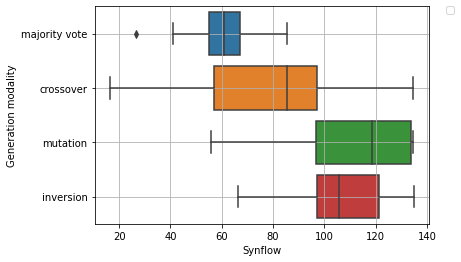

In [ ]:
# we considered onlly the last generated models, because at the start the algorithm starts exploring 
# with a population with random models, in the last ones all the elements of the population
# were generated in order to increase the metric
# so we thought that could be more rapresentative to plot this situation to better understand the
# difference between the generation modalities

seaborn.boxplot(data=csv_df.iloc[220:300],x="syn", y ="mode")
plt.grid()
pyplot.legend(bbox_to_anchor=(1.05,1),loc = 2, borderaxespad=0.)
pyplot.xlabel('Synflow')
pyplot.ylabel('Generation modality')
pyplot.savefig('gen.pdf',dpi=300,bbox_inches='tight')

#Random search with synflow

Results of this test (random_syn.csv) are already available on the Files section (downloaded from github)

Please remember to delete this file if you want to replilcate this test

In [ ]:
# same code as before, calculating synflow
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  return np.log(syn)
  

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from scipy import stats
import torch
import time
import operator
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datasetNames = ['cifar10','cifar100','ImageNet16-120']

runs = 10
sample_size = 200
batch_size = 128

for dataset in datasetNames:  
  for run in range(runs):

    train_loader = get_data(dataset, batch_size)
    scores = []
    nets = np.random.randint(0,len(api),size=sample_size)
    counter = 0

    start = time.time()

    for i in nets:
      scores.append(get_score(dataset,int(i),api,train_loader,run,'child'))

    ind_best = np.argmax(scores)
    acc = api.get_more_info(int(nets[ind_best]),dataset,is_random=False,hp=200)['test-accuracy']
    tempo = time.time()-start
    csv_dict = {'Dataset': dataset, 'Network': nets[ind_best], 'Metric': scores[ind_best], 'Accuracy': acc, 'Time': tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('random_syn.csv', mode='a', index=False, header=False )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
